# Predicting Sentiment Levels on Yelp Reviews
## STAT 628 Mon, Group 6, Module 2

## Abstract
Using Rooted Mean Square Error (RMSE) as the performance evalution metric, our score reached 0.57998 on the Kaggle public leaderboard and about 0.56 in our own cross-validation (CV) process. We applied ECOC and NBSVM combined with Xgboost to predict the sentiment levels, also demonstrated by the number of stars, in Yelp reviews.

## Introduction
In the project, the data set includes about 2.6 million reviews from Yelp, which is divided into training set(1.5 million) and test set(1.1 million). Our aim is to fit a proper model to predict the ranking of the Yelp reviews.

## Data Overview and Cleaning

In [1]:
import pandas as pd
from IPython.display import Image
df = pd.read_csv("/Users/yilixia/Downloads/stat628/train_translation.csv")
train = df.loc[range(100000),['stars','text']]
df.shape

(1546379, 2)

### Translation
More than 99% of the reviews were written in English while the rest of the reviews are in multiple languages including French, Japanese, German, Chinese (Simplified, Traditional and Cantonese). Most of them are well written reviews and contain beneficial information for our future models. Therefore, we decided to translate all the reviews.

In [2]:
# Examples of translated text:
print(df.loc[1489714,'stars'],"-",df.loc[1489714,'text'])
print(df.loc[1286432,'stars'],"-",df.loc[1286432,'text'])

5 - Clean environment .. Address is not very remote. Waiter enthusiasm .... 10-minute drive from the center of Las Vegas.
3 - The interior decoration is very beautiful, things out too slow, the food is very beautiful, but things like the general! Ten dollars on the price a bit too expensive. Will I be too picky!


The information that one review is written in a non-English language wasn't used as a feature label since doing a chi-square test, the results demonstrate that there isn't a significant difference in the distribution of stars between  English reviews and non-English reviews (p-value=0.2202).

### And that's all for cleaning
Yes, we are aware of that there are still aspects in text data on which we didn't consider for the following reasons:

* Uninformative reviews: There are some reviews which contain meaningless text like 'X', 'V', 'O' and 'y' in both the train and test set on which no valid prediction could be made. However, they were automatically excluded during the tokenization process due to `min_df`.
* Hyperlinks: There are two hyperlinks in the text data which were also ignored during the tokenization process.

In [3]:
import re, string
from sklearn.feature_extraction.text import TfidfVectorizer
re_tok = re.compile(f'([{string.punctuation}“”¨«»®´·º½¾¿¡§£₤‘’])')
def tokenize(s): return re_tok.sub(r' \1 ', s).split()
vec = TfidfVectorizer(ngram_range=(1, 2), tokenizer=tokenize,
                      min_df=0.0003, max_df=0.9, strip_accents='unicode', use_idf=1,
                      smooth_idf=1, sublinear_tf=1)

* Stopwords and Snippets dataset: As stated in the paper [Sida&Christopher, 2012](#Sida&Christopher2012), it is not necessary to exclude stopwords and their method performs well on predicting snippet datasets like 'not bad' and 'do not recommend'. Therefore, we did nothing to handle them.
* Mistyped words: This is one of the categories we tried to deal with. However, we couldn't come up with some general rules to correct mistyped words and manual selection would be exhaustive and trivial in improvement. In the meantime, existing spell checking methods such as Enchant are not only slow but also imprecise. Therefore, we didn't do anything for this part.

### Simple features based on the reviews

To extract more information from the reviews other than bag of words, we came up with 11 simple features:

1. The number of sentences in each comment
2. Word count in each comment
3. Unique word count
4. Letter count
5. Punctuation count
6. Upper case words count
7. Title case words count
8. Number of stopwords
9. Average length of the words
10. Percentage of unique words in each comment
11. Percentage of punctuations in each comment

### Years
The dates of the Yelp reviews were included into the data, as shown in the plot below, there is a significant trend in the stars over the years, hence we believe that it would be helpful to include them into our model.

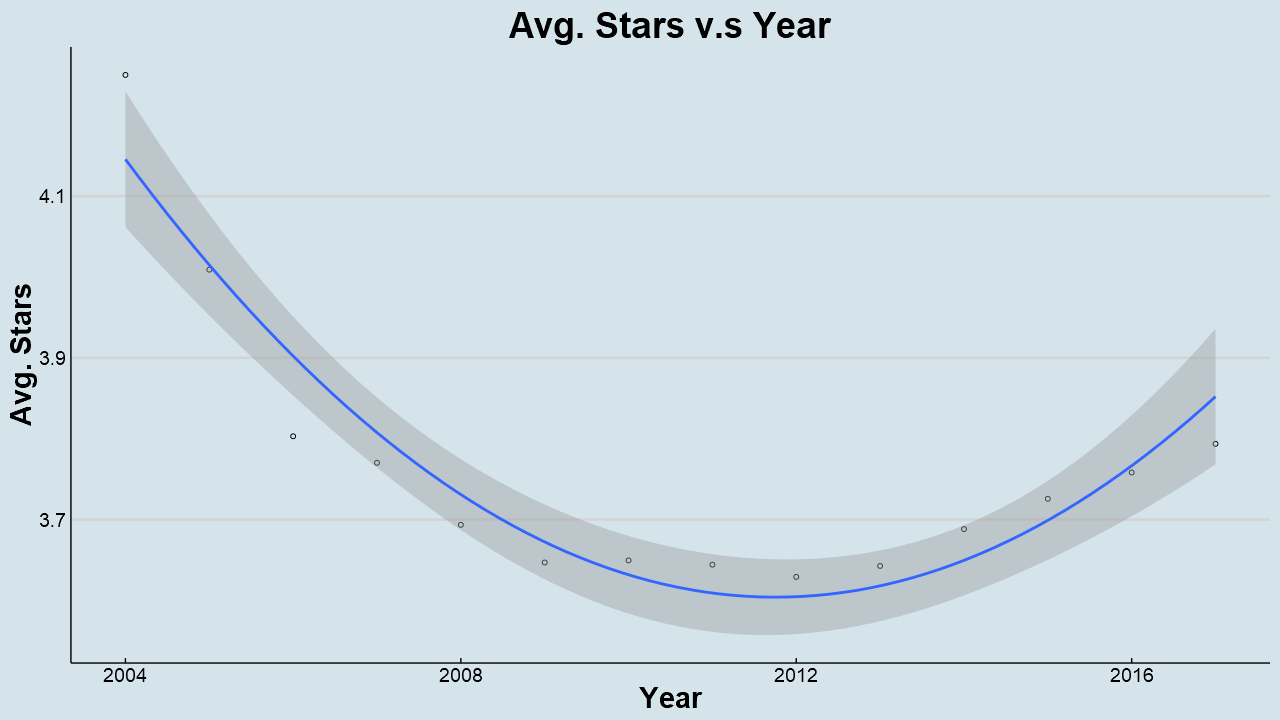

In [4]:
Image("../Plots/star_year.png",width=800, height=400)

## Model
### ECOC

Inspired by the trending Kaggle competition on predicting toxic comments ([Kaggle](#Toxic)), we redefined the problem to a binary one vs all problem by asking the question *"Is the review a 1/2/3/4/5 star review?"* or *"What is the probability that the review is a 1/2/3/4/5 star review?"* five times instead of predicting the stars of the reviews in one run. This process is also know as Error-Correcting Output Coding (ECOC) introduced by Dietterich et al ([Dietterich et al, 1991](#Dietterich1991))([Dietterich&Bakiri, 1995](#Dietterich1995)) and is used for improving the performance of multiclass learning problems by separating multiple classes using the Hamming distance.

In [5]:
label_cols = ['1', '2', '3', '4', '5']

for i in label_cols:
    train[i] = (train['stars'] == int(i))
print(train[['stars','1','2','3','4','5']][6:11])

    stars      1      2      3      4      5
6       1   True  False  False  False  False
7       4  False  False  False   True  False
8       3  False  False   True  False  False
9       3  False  False   True  False  False
10      5  False  False  False  False   True


There are many advantages under the new framework. Besides the advantages that were already introduced in the paper, such as that there are many available methods which do binary classification or predicting problems better and faster than multiclass classification problems, applying ECOC also provides a natural smoothing procedure by calculating the predicted stars using the mean or expectation to a real value instead of an integer. Hence it would more likely to decrease the RMSE. 

Of course, Dietterich also pointed out that ECOC comes with some additional costs ([Dietterich&Bakiri, 1995](#Dietterich1995)). It would increase the complexity of the model as well as the training time. However, in our case, we were looking for better prediction performance thus a complicated model would only be of our least concern. Furthermore, the train-predict time was actually incredibly fast. It would usually take a little less than 3 minutes (170s) to train on 200,000 and predict on 200,000 samples using NB/SVM which we'll introduce in the section below.

### NBSVM
NBSVM, short for Naive Bayes Support Vector Machines (NBSVM), was introduced by Sida and Christopher ([Sida&Christopher, 2012](#Sida&Christopher2012)) in 2012 and is a prevailing method in Kaggle competitions. It had been confirmed by Rennie et al ([Rennie et al, 2001](#Rennie2001)) that the Support Vector Machine (SVM) consistently outperforms the Naive Bayes (NB) while both of them are popular sentiment classifying methods in previous researches. Though this finding is consistent with our experience on the Yelp sentiment prediction, SVM alone was never enough to cross the pre-set borderline (RMSE=0.71). In his paper, Sida stated that NB is better at snippets while SVM is better at full-length reviews. By combining the advantages of NB and SVM, NBSVM either exceeds or approaches most of the previous methods including those that use sentiment lexicons and hard-coded reversal rules.

Combining ECOC and NBSVM ([NBSVM-Code](#Code)), we estimated the probability of whether the review is a 1/2/3/4/5 star review. Afterwards, we used the expectation, which was calculated by multiplying the number of stars with the normalized probabilities, as our predicted sentiment level and reached a Kaggle public leaderboard score of 0.68886 and a RMSE of about 0.63 using CV with 200,000 samples as training set and 200,000 samples as testing set.

### XGBoost

Aiming to provide a "Scalable, Portable and Distributed Gradient Boosting (GBM, GBRT, GBDT) Library", XGBoost is an famous open source library which provides the gradient boosting framework. Generally speaking, it combines several prediction results from different decision trees, which is so called 'ensemable of weak prediction model'. The algorithm initially introduced by Tianqi Chen in 2016 and soon became popular among Kaggle community.([Wikipedia XGBoost](#wikixgboost))

When using single algorithms to conduct the cross validation, the preformance of XGBoost had been among the top tier. Therefore XGBoost was one of the top candidates in the following model combination step. In fact, when we chose NBSVM as the first model, Xgboost performed best as the second model comparing with other machine learning algorithms.

Using the output of NBSVM, which is the probability of 1/2/3/4/5 stars, as the input of Xgboost, we reached a Kaggle leaderboard score of 0.59237.

To further improve the model performance, the natural idea is to feed more information into XGBoost. Therefore we extracted years and some simple features based on reviews and combined them with the output of NBSVM as the input of XGBoost. As result, the Kaggle leaderboard score decreased to 0.58263.

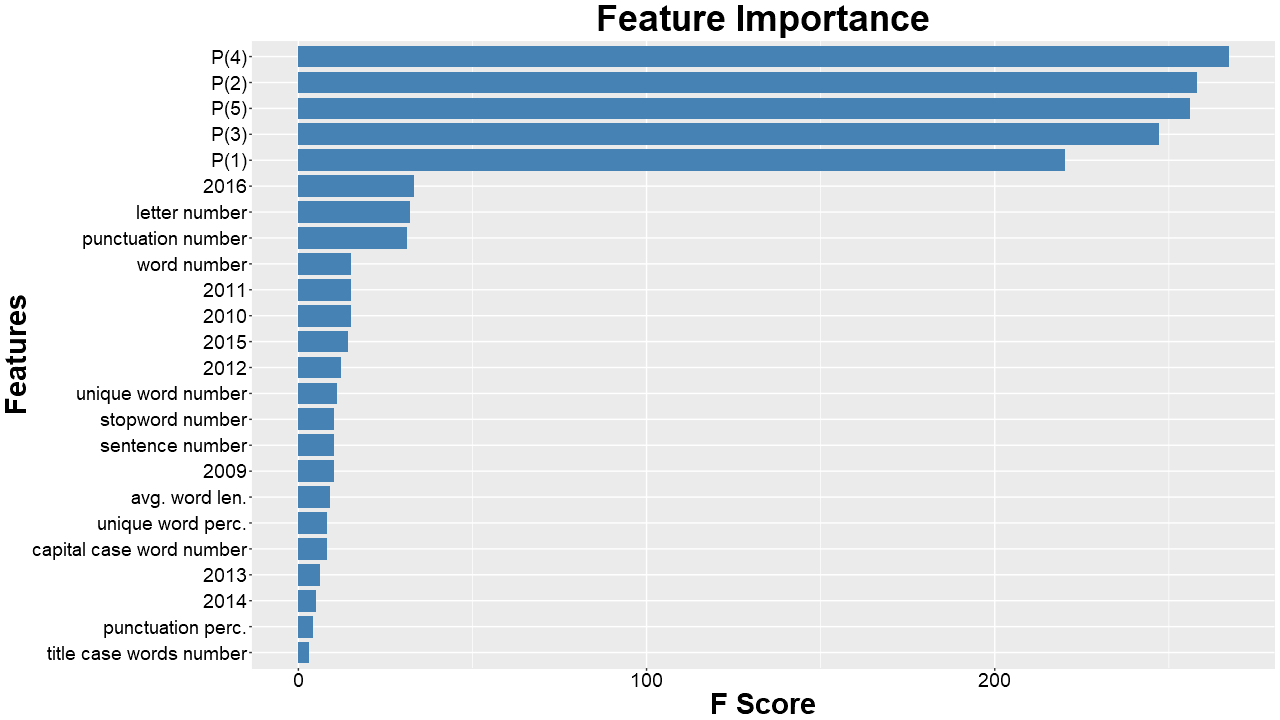

In [6]:
Image("../Plots/feature importance.png",width=800, height=400)

### Model combination
Empirically, combining different methods where the predictions are relatively accurate and uncorrelated will improve the prediction performance. Supposed there are two models, model 1 and model 2. There may be data points where model 1 predicts better, but for some reason it performs terribly on others. Instead, model 2 may have a better overall performance on all the data points, but it has worse performance on the very set of points where model 1 is better. The idea is to combine these two models where they perform the best.([Stacking Models for Improved Predictions](#stacking))

## Conclusion
### Timeline
Here is the timeline that shows how we get our final result based on 50000 train data. Among all methods we've implemented, the NBSVM model is significantlly better than others:

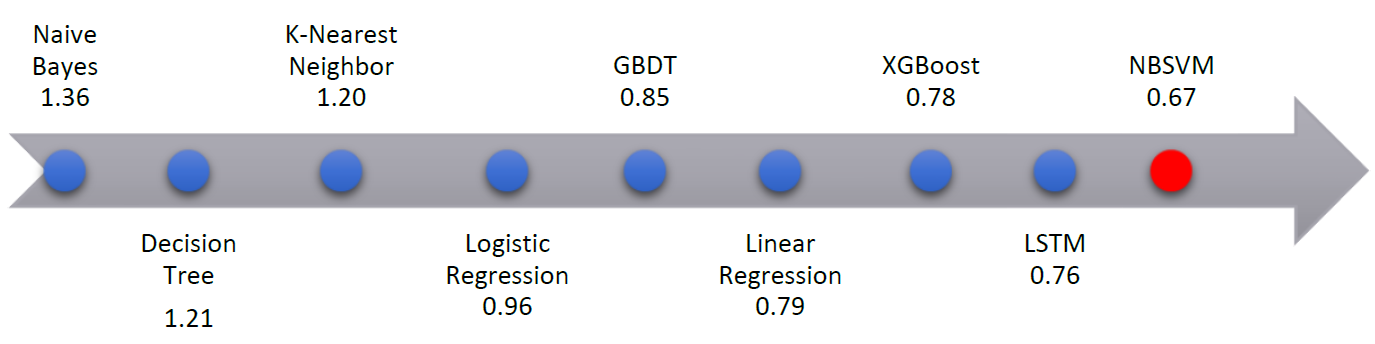

In [7]:
Image("../Plots/offline timeline.png",width=800, height=400)

To further improve our model, we've tried 4 different ways training on the whole data set to get the best performance. These are results that were published online to Kaggle:

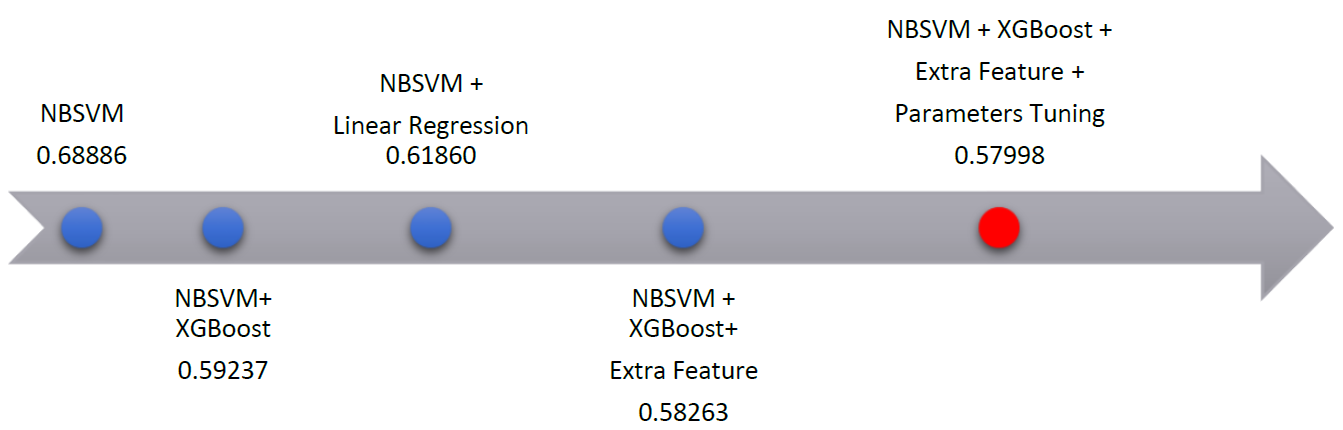

In [8]:
Image("../Plots/online timeline.png",width=800, height=400)

### Pros
1. Precision: This model has one of the best performance among all groups until 3/11 with a RMSE score of 0.57998 on the public leaderboard. 
2. Speed: It only takes about 30 minutes to fit and predict the entire model.
3. Robustness: The more data you fit into the model, the better the result will become.
4. Simplicity: The model is easy to understand and implement.

### Cons

1. Typos weren't corrected hence they could influence the precision of our model.
2. There had always been a gap between the results on the public leaderboard and the offline CV.

### Future work
1. Inplement stacking method on NBSVM model.(By using Cross Validation)
2. Check and modify tpyos.
3. Inplement ensembling method on XGBoost model.(By Voting)

## Reference
1. <a id='Toxic'></a>https://www.kaggle.com/c/jigsaw-toxic-comment-classification-challenge
2. <a id='Dietterich1991'></a>Dietterich, Thomas G., and Ghulum Bakiri. "Error-correcting output codes: A general method for improving multiclass inductive learning programs." AAAI. 1991.
3. <a id='Dietterich1995'></a>Dietterich, Thomas G., and Ghulum Bakiri. "Solving multiclass learning problems via error-correcting output codes." Journal of artificial intelligence research 2 (1995): 263-286.
4. <a id='Sida&Christopher2012'></a>Wang, Sida, and Christopher D. Manning. "Baselines and bigrams: Simple, good sentiment and topic classification." Proceedings of the 50th Annual Meeting of the Association for Computational Linguistics: Short Papers-Volume 2. Association for Computational Linguistics, 2012.
5. <a id='Rennie2001'></a>Rennie, Jason DM, and Ryan Rifkin. "Improving multiclass text classification with the support vector machine." (2001).
6. <a id='Code'></a>NBSVM Codes: https://github.com/sidaw/nbsvm; https://github.com/mesnilgr/nbsvm; https://www.kaggle.com/jhoward/nb-svm-strong-linear-baseline
7. <a id='wikixgboost'></a>https://en.wikipedia.org/wiki/Xgboost
8. <a id='stacking'></a>https://www.kdnuggets.com/2017/02/stacking-models-imropved-predictions.html

| Name        | Contribution |
|-------------|------|
| Qizheng Ren |  Translation; Xgboost model Stacking idea; Parameters tuning;Notebook(Conclusion);Presentation    |
| Hanmo Li    |  Feature Selection; Model fitting(sklearn); Notebook(simple feature, XGBoost); Presentation    |
| Lixia Yi    | Model checking and testing;Notebook writing (Data overview,ECOC,NBSVM);Presentation|
| Jiacheng Xu | Model testing; Making plots;Presentation     |